In [ ]:
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [ ]:
#!pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
#pip install pytesseract

In [ ]:
#pip install mss

In [ ]:
#pip install tensorboard==1.14.0

In [ ]:
#pip install pydirectinput

In [2]:
pip list

Package                    Version
-------------------------- ------------
absl-py                    1.1.0
ale-py                     0.7.5
asttokens                  2.0.5
AutoROM                    0.4.2
AutoROM.accept-rom-license 0.4.2
backcall                   0.2.0
cachetools                 5.2.0
certifi                    2022.6.15
charset-normalizer         2.0.12
click                      8.1.3
cloudpickle                2.1.0
colorama                   0.4.5
cycler                     0.11.0
debugpy                    1.6.0
decorator                  5.1.1
entrypoints                0.4
executing                  0.8.3
fonttools                  4.33.3
google-auth                2.8.0
google-auth-oauthlib       0.4.6
grpcio                     1.46.3
gym                        0.21.0
idna                       3.3
importlib-metadata         4.11.4
importlib-resources        5.8.0
ipykernel                  6.15.0
ipython                    8.4.0
jedi                       

In [1]:
#MSS used for screen cap
from mss import mss
# Sending commands
import pydirectinput
#Frame processing
import cv2
#Transformational framework
import numpy as np
#OCR for game over extraction
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
#Visualize captured frames
from matplotlib import pyplot as plt
#Time pauses
import time
#Gym components
from gym import Env
from gym.spaces import Box, Discrete

## Create environment

In [2]:
class WebGame(Env):
    #Setup the env action & observation shapes
    def __init__(self):
        
        #Subclass model
        super().__init__()
        
        #Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        #define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':150, 'left':0, 'width':600, 'height':500}
        self.done_location = {'top':350, 'left':410, 'width':330, 'height':100}
    
    
    #What is called to do something in the game
    def step(self, action):
        #Action key - 0=jump, 1=duck, 2=no action
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])
        #Checking whether the game is done
        done, done_cap = self.get_done()
        #Get the next observation 
        new_observation = self.get_observation()
        #Reward - we get a point for every frame we're alive
        reward=1
        #Info dictionary
        info={}
        return new_observation, reward, done, info
    
    #Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    #Restart the game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150,y=300)
        pydirectinput.press('space')
        return self.get_observation()
    
    #Closes down the observation
    def close(self):
        cv2.destroyAllWindows()
    
    #Get the part of the observation of the game that we want
    def get_observation(self):
        #Get screen capture of the game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        #Resize
        resized = cv2.resize(gray, (100,83))
        #Add channels first
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    
    #Get the done text
    def get_done(self):
        #Get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        #Valid done text
        done_strings = ['GAME','GAHE']
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done,done_cap
    

### Test observations

In [3]:
env = WebGame()

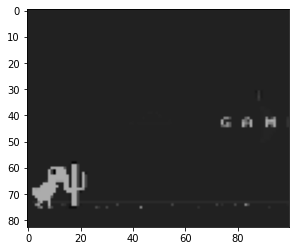

In [4]:
obs = env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

True


'GAME Os\n'

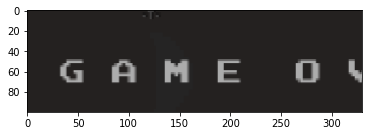

In [5]:
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)
pytesseract.image_to_string(done_cap)

### Train the model

In [6]:
for episode in range(1):
    obs = env.reset()
    done = False
    total_reward = 0 
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
          
    print( f'Total Reward for episode {episode} is {total_reward}')

Total Reward for episode 0 is 11


### Create callback

In [6]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

D:\Personal_Projects\Chrome Dino Game\dino\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
env_checker.check_env(env)

In [7]:
class TrainAndLogginCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLogginCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [13]:
callback = TrainAndLogginCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

 ### Build and train DQN algo

In [8]:
from stable_baselines3 import DQN

In [9]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000,learning_starts=1000)

NameError: name 'LOG_DIR' is not defined

In [16]:
%%time
#Kick off training
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.25     |
|    ep_rew_mean      | 9.25     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 28       |
|    total_timesteps  | 37       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.75     |
|    ep_rew_mean      | 9.75     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 54       |
|    total_timesteps  | 78       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.67     |
|    ep_rew_mean      | 9.67     |
|    exploration_rate | 0.989    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 1        |
|    time_elapsed     | 659      |
|    total_timesteps  | 1060     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 14       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 1        |
|    time_elapsed     | 684      |
|    total_timesteps  | 1100     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0487   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 1        |
|    time_elapsed     | 1102     |
|    total_timesteps  | 1766     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.61e-05 |
|    n_updates        | 191      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 1        |
|    time_elapsed     | 1129     |
|    total_timesteps  | 1814     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.75e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1        |
|    time_elapsed     | 1529     |
|    total_timesteps  | 2456     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24e-05 |
|    n_updates        | 363      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.762    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 1        |
|    time_elapsed     | 1555     |
|    total_timesteps  | 2501     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.96e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.694    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 1        |
|    time_elapsed     | 1997     |
|    total_timesteps  | 3226     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38e-05 |
|    n_updates        | 556      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 1        |
|    time_elapsed     | 2024     |
|    total_timesteps  | 3268     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.37e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 1        |
|    time_elapsed     | 2451     |
|    total_timesteps  | 3945     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.57e-06 |
|    n_updates        | 736      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 352      |
|    fps              | 1        |
|    time_elapsed     | 2477     |
|    total_timesteps  | 3986     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.77e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.553    |
| time/               |          |
|    episodes         | 412      |
|    fps              | 1        |
|    time_elapsed     | 2917     |
|    total_timesteps  | 4709     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.04e-06 |
|    n_updates        | 927      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.549    |
| time/               |          |
|    episodes         | 416      |
|    fps              | 1        |
|    time_elapsed     | 2943     |
|    total_timesteps  | 4752     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.77e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.486    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 1        |
|    time_elapsed     | 3345     |
|    total_timesteps  | 5409     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.24e-06 |
|    n_updates        | 1102     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.482    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 1        |
|    time_elapsed     | 3370     |
|    total_timesteps  | 5448     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.74e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.421    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1        |
|    time_elapsed     | 3776     |
|    total_timesteps  | 6098     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.76e-06 |
|    n_updates        | 1274     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.417    |
| time/               |          |
|    episodes         | 544      |
|    fps              | 1        |
|    time_elapsed     | 3806     |
|    total_timesteps  | 6142     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 604      |
|    fps              | 1        |
|    time_elapsed     | 4237     |
|    total_timesteps  | 6859     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.17e-06 |
|    n_updates        | 1464     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 608      |
|    fps              | 1        |
|    time_elapsed     | 4264     |
|    total_timesteps  | 6897     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.61e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.281    |
| time/               |          |
|    episodes         | 668      |
|    fps              | 1        |
|    time_elapsed     | 4679     |
|    total_timesteps  | 7572     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09e-05 |
|    n_updates        | 1642     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 672      |
|    fps              | 1        |
|    time_elapsed     | 4705     |
|    total_timesteps  | 7614     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.81e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.207    |
| time/               |          |
|    episodes         | 732      |
|    fps              | 1        |
|    time_elapsed     | 5143     |
|    total_timesteps  | 8348     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99e-06 |
|    n_updates        | 1836     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes         | 736      |
|    fps              | 1        |
|    time_elapsed     | 5171     |
|    total_timesteps  | 8391     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.15e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.14     |
| time/               |          |
|    episodes         | 796      |
|    fps              | 1        |
|    time_elapsed     | 5594     |
|    total_timesteps  | 9055     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.38e-06 |
|    n_updates        | 2013     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.135    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 1        |
|    time_elapsed     | 5620     |
|    total_timesteps  | 9101     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.7e-06  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.072    |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1        |
|    time_elapsed     | 6035     |
|    total_timesteps  | 9768     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.92e-06 |
|    n_updates        | 2191     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.3     |
|    ep_rew_mean      | 11.3     |
|    exploration_rate | 0.0677   |
| time/               |          |
|    episodes         | 864      |
|    fps              | 1        |
|    time_elapsed     | 6062     |
|    total_timesteps  | 9814     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.7     |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 1        |
|    time_elapsed     | 6505     |
|    total_timesteps  | 10530    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0247   |
|    n_updates        | 2382     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 928      |
|    fps              | 1        |
|    time_elapsed     | 6532     |
|    total_timesteps  | 10592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00241  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.3     |
|    ep_rew_mean      | 12.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 1        |
|    time_elapsed     | 6964     |
|    total_timesteps  | 11314    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0109   |
|    n_updates        | 2578     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.4     |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 992      |
|    fps              | 1        |
|    time_elapsed     | 6992     |
|    total_timesteps  | 11352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 1        |
|    time_elapsed     | 7509     |
|    total_timesteps  | 12250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00774  |
|    n_updates        | 2812     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 1        |
|    time_elapsed     | 7538     |
|    total_timesteps  | 12296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0139   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.1     |
|    ep_rew_mean      | 15.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 1        |
|    time_elapsed     | 8033     |
|    total_timesteps  | 13154    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00673  |
|    n_updates        | 3038     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.8     |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 1        |
|    time_elapsed     | 8059     |
|    total_timesteps  | 13201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0136   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 1        |
|    time_elapsed     | 8483     |
|    total_timesteps  | 13867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00878  |
|    n_updates        | 3216     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1184     |
|    fps              | 1        |
|    time_elapsed     | 8509     |
|    total_timesteps  | 13904    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0138   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 1        |
|    time_elapsed     | 9202     |
|    total_timesteps  | 15155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00998  |
|    n_updates        | 3538     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1248     |
|    fps              | 1        |
|    time_elapsed     | 9234     |
|    total_timesteps  | 15209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00108  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 1        |
|    time_elapsed     | 9678     |
|    total_timesteps  | 15937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0233   |
|    n_updates        | 3734     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.9     |
|    ep_rew_mean      | 16.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 1        |
|    time_elapsed     | 9705     |
|    total_timesteps  | 15992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00341  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 12.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 1        |
|    time_elapsed     | 10143    |
|    total_timesteps  | 16802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000682 |
|    n_updates        | 3950     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 12.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1376     |
|    fps              | 1        |
|    time_elapsed     | 10169    |
|    total_timesteps  | 16843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0136   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 13.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 1        |
|    time_elapsed     | 10619    |
|    total_timesteps  | 17638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000189 |
|    n_updates        | 4159     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 13.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 1        |
|    time_elapsed     | 10645    |
|    total_timesteps  | 17688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00201  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.1     |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 1        |
|    time_elapsed     | 11082    |
|    total_timesteps  | 18400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0202   |
|    n_updates        | 4349     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.1     |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 1        |
|    time_elapsed     | 11109    |
|    total_timesteps  | 18445    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000539 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 1        |
|    time_elapsed     | 11534    |
|    total_timesteps  | 19151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00113  |
|    n_updates        | 4537     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.2     |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1568     |
|    fps              | 1        |
|    time_elapsed     | 11580    |
|    total_timesteps  | 19266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000194 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 14.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 1        |
|    time_elapsed     | 12055    |
|    total_timesteps  | 20142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.03     |
|    n_updates        | 4785     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 1        |
|    time_elapsed     | 12095    |
|    total_timesteps  | 20223    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0489   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20       |
|    ep_rew_mean      | 20       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 1        |
|    time_elapsed     | 12807    |
|    total_timesteps  | 21561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0498   |
|    n_updates        | 5140     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 20.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1696     |
|    fps              | 1        |
|    time_elapsed     | 12855    |
|    total_timesteps  | 21653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00639  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.4     |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 1        |
|    time_elapsed     | 13549    |
|    total_timesteps  | 22925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0145   |
|    n_updates        | 5481     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.6     |
|    ep_rew_mean      | 21.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 1        |
|    time_elapsed     | 13606    |
|    total_timesteps  | 23034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.046    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 1        |
|    time_elapsed     | 14355    |
|    total_timesteps  | 24534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0572   |
|    n_updates        | 5883     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1824     |
|    fps              | 1        |
|    time_elapsed     | 14394    |
|    total_timesteps  | 24603    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0187   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.2     |
|    ep_rew_mean      | 25.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 1        |
|    time_elapsed     | 15136    |
|    total_timesteps  | 26037    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 6259     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.4     |
|    ep_rew_mean      | 24.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1888     |
|    fps              | 1        |
|    time_elapsed     | 15171    |
|    total_timesteps  | 26099    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00517  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.3     |
|    ep_rew_mean      | 23.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 1        |
|    time_elapsed     | 15914    |
|    total_timesteps  | 27493    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00934  |
|    n_updates        | 6623     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 23.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1952     |
|    fps              | 1        |
|    time_elapsed     | 15979    |
|    total_timesteps  | 27625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00482  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2012     |
|    fps              | 1        |
|    time_elapsed     | 16653    |
|    total_timesteps  | 28861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0107   |
|    n_updates        | 6965     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2016     |
|    fps              | 1        |
|    time_elapsed     | 16705    |
|    total_timesteps  | 28947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0291   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.7     |
|    ep_rew_mean      | 22.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2076     |
|    fps              | 1        |
|    time_elapsed     | 17450    |
|    total_timesteps  | 30309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00785  |
|    n_updates        | 7327     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.4     |
|    ep_rew_mean      | 22.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 1        |
|    time_elapsed     | 17483    |
|    total_timesteps  | 30365    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0352   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 1        |
|    time_elapsed     | 18188    |
|    total_timesteps  | 31714    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0827   |
|    n_updates        | 7678     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22       |
|    ep_rew_mean      | 22       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2144     |
|    fps              | 1        |
|    time_elapsed     | 18232    |
|    total_timesteps  | 31790    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0257   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 1        |
|    time_elapsed     | 18911    |
|    total_timesteps  | 33102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0148   |
|    n_updates        | 8025     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.2     |
|    ep_rew_mean      | 21.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 1        |
|    time_elapsed     | 18952    |
|    total_timesteps  | 33181    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00227  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 1        |
|    time_elapsed     | 19679    |
|    total_timesteps  | 34605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0158   |
|    n_updates        | 8401     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.8     |
|    ep_rew_mean      | 22.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2272     |
|    fps              | 1        |
|    time_elapsed     | 19720    |
|    total_timesteps  | 34686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0192   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.4     |
|    ep_rew_mean      | 24.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2332     |
|    fps              | 1        |
|    time_elapsed     | 20477    |
|    total_timesteps  | 36116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates        | 8778     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 23.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2336     |
|    fps              | 1        |
|    time_elapsed     | 20510    |
|    total_timesteps  | 36169    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00303  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2396     |
|    fps              | 1        |
|    time_elapsed     | 21185    |
|    total_timesteps  | 37369    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0805   |
|    n_updates        | 9092     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 1        |
|    time_elapsed     | 21242    |
|    total_timesteps  | 37468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0751   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 1        |
|    time_elapsed     | 21990    |
|    total_timesteps  | 38921    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0058   |
|    n_updates        | 9480     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.2     |
|    ep_rew_mean      | 23.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2464     |
|    fps              | 1        |
|    time_elapsed     | 22033    |
|    total_timesteps  | 39019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2524     |
|    fps              | 1        |
|    time_elapsed     | 22684    |
|    total_timesteps  | 40168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.074    |
|    n_updates        | 9791     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2528     |
|    fps              | 1        |
|    time_elapsed     | 22719    |
|    total_timesteps  | 40213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0406   |
|    n_updates      

FailSafeException: PyDirectInput fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pydirectinput.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

### Testing

In [33]:
model1 = DQN.load(os.path.join('train','best_model_40000'))


In [35]:
for episode in range(25):
    obs = env.reset()
    done = False
    total_reward = 0 
    
    while not done:
        action , _ = model1.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
          
    print( f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Total Reward for episode 0 is 19
Total Reward for episode 1 is 17
Total Reward for episode 2 is 21


FailSafeException: PyDirectInput fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pydirectinput.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.